In [77]:
import numpy as np
import pandas as pd

In [104]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/abir_try_SVR_conv


In [2]:
import xarray as xr
import hilbert_data1_jgrjd_20CRV3
import datetime
import matplotlib.pyplot as plt

In [53]:
df = xr.open_dataset('trop_sfc.ano_1905-2015_filtered_rm_mean120.nc')

In [78]:
df

<xarray.Dataset>
Dimensions:   (lat: 61, lon: 360, time: 40422)
Coordinates:
  * time      (time) datetime64[ns] 1905-05-01 1905-05-02 ... 2015-12-31
  * lon       (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat       (lat) float32 -30.0 -29.0 -28.0 -27.0 ... 27.0 28.0 29.0 30.0
Data variables:
    pres_ano  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Sat Jan 18 20:13:44 2020: cdo -O -sellonlatbox,0,360,-30,30...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [54]:
_,_,y_train = hilbert_data1_jgrjd_20CRV3.data_hilbert(datetime.datetime(1979,1,1),datetime.datetime(2008,12,31))
_,_,y_test = hilbert_data1_jgrjd_20CRV3.data_hilbert(datetime.datetime(1974,6,1),datetime.datetime(1978,3,16))

In [89]:
df_test3

<xarray.Dataset>
Dimensions:   (lat: 51, lon: 360, time: 40422)
Coordinates:
  * time      (time) datetime64[ns] 1905-05-01 1905-05-02 ... 2015-12-31
  * lon       (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat       (lat) float32 -25.0 -24.0 -23.0 -22.0 ... 22.0 23.0 24.0 25.0
Data variables:
    pres_ano  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Sat Jan 18 20:13:44 2020: cdo -O -sellonlatbox,0,360,-30,30...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [96]:
#df_test3 = df.sel(lat=slice(-25,25))
xtest3 = df_test3.pres_ano.values[:,:,:]

In [91]:
y_test.index[0],y_train.index[-1]

(Timestamp('1974-09-28 00:00:00'), Timestamp('2008-12-31 00:00:00'))

In [57]:
df_train = df.sel(time=slice(str(y_train.index[0]),str(y_train.index[-1])),lat=slice(-25,25))
df_test = df.sel(time=slice(str(y_test.index[0]),str(y_test.index[-1])),lat=slice(-25,25))

In [58]:
xtrain = df_train.pres_ano.values[:,:,:]
xtest  = df_test.pres_ano.values[:,:,:]

In [59]:
ff = xtrain.flatten()

(array([2.5015000e+04, 3.7370000e+04, 5.8351000e+04, 9.3126000e+04,
        1.5287200e+05, 2.5961300e+05, 4.5514900e+05, 8.2814800e+05,
        1.5806060e+06, 3.2569910e+06, 7.4372510e+06, 1.8270198e+07,
        3.7479061e+07, 5.1180289e+07, 4.1295804e+07, 2.1585349e+07,
        8.7865530e+06, 3.5105510e+06, 1.5003280e+06, 6.4482900e+05,
        2.8423700e+05, 1.2463800e+05, 5.3451000e+04, 2.3575000e+04,
        1.0677000e+04, 4.9440000e+03, 2.5370000e+03, 1.4120000e+03,
        8.7500000e+02, 5.5800000e+02, 3.8300000e+02, 2.0900000e+02,
        1.1900000e+02, 3.7000000e+01, 1.4000000e+01]),
 array([-999.9873  , -926.1257  , -852.26404 , -778.4024  , -704.54083 ,
        -630.6792  , -556.81757 , -482.95593 , -409.0943  , -335.2327  ,
        -261.37106 , -187.50943 , -113.64781 ,  -39.786186,   34.07544 ,
         107.937065,  181.79869 ,  255.66031 ,  329.52194 ,  403.38358 ,
         477.24518 ,  551.1068  ,  624.96844 ,  698.8301  ,  772.6917  ,
         846.5533  ,  920.4149  ,  9

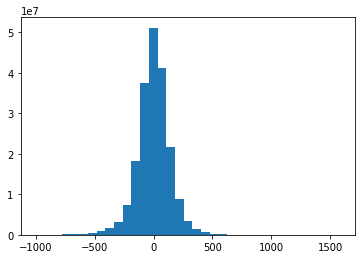

In [60]:
plt.hist(ff[~(ff<-1000)],bins=35)

In [61]:
xtrain = xtrain[:,:,:,None]
xtest  = xtest[:,:,:,None]

In [62]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,AveragePooling2D

model = Sequential()

model.add(Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=(xtrain.shape[1],xtrain.shape[2],1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=12, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dense(units=1, activation = 'linear'))

In [63]:
xtrain.shape,y_train.shape

((10839, 51, 360, 1), (10839, 1))

In [64]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='mae')

history = model.fit(xtrain, y_train.values, validation_data=(xtest, y_test.values), epochs=3)

Train on 10839 samples, validate on 1266 samples
Epoch 1/3
10839/10839 [==============================] - 15s 1ms/step - loss: 1.6764 - val_loss: 0.4475
Epoch 2/3
10839/10839 [==============================] - 14s 1ms/step - loss: 0.3401 - val_loss: 0.3853
Epoch 3/3
10839/10839 [==============================] - 14s 1ms/step - loss: 0.2885 - val_loss: 0.3865


In [65]:
yy_test = model.predict(xtest)

In [66]:
yy_test.shape,y_test.shape

((1266, 1), (1266, 1))

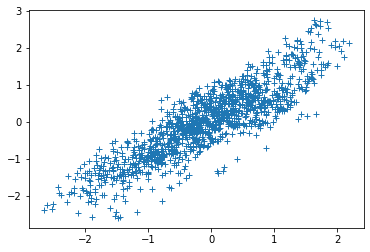

In [67]:
plt.plot(yy_test,y_test,'+')

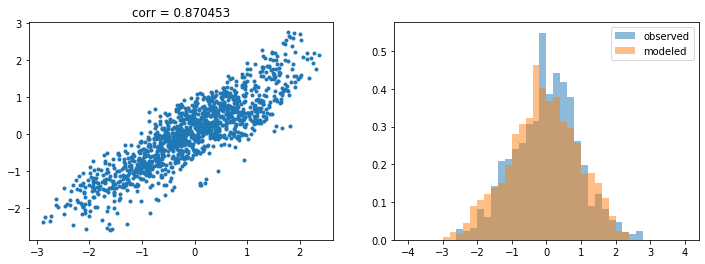

In [68]:
yy_test = model.predict(xtest)
test_corr = np.corrcoef(yy_test[:,0],y_test.values[:,0])[0,1]
yy_test   = yy_test[:,0]/yy_test[:,0].std()

# print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test,y_test.values[:,0],'.')

ax[0].set_title('corr = %f'%test_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

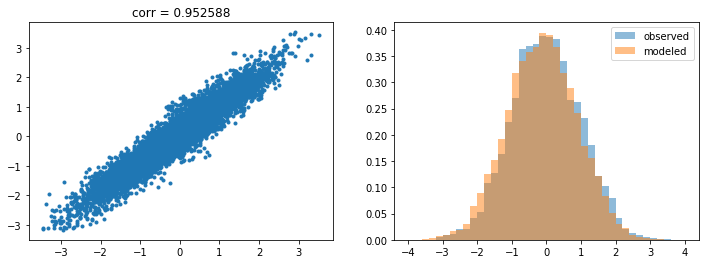

In [69]:
yy_train = model.predict(xtrain)
train_corr = np.corrcoef(yy_train[:,0],y_train.values[:,0])[0,1]
yy_train   = yy_train[:,0]/yy_train[:,0].std()

# print("train shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_train,y_train.values[:,0],'.')

ax[0].set_title('corr = %f'%train_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_train.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_train,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

In [97]:
xtest3 = xtest3[:,:,:,None]

In [98]:
rmm2 = model.predict(xtest3)

In [99]:
rmm2 = pd.DataFrame(rmm2,index=pd.to_datetime(df_test3.time[:].values),columns=['rmm2'])

(array([2.000e+00, 3.000e+00, 8.000e+00, 2.300e+01, 2.000e+01, 4.600e+01,
        9.100e+01, 1.560e+02, 3.450e+02, 5.600e+02, 8.440e+02, 1.319e+03,
        1.811e+03, 2.632e+03, 3.350e+03, 3.864e+03, 4.245e+03, 4.402e+03,
        4.029e+03, 3.540e+03, 2.837e+03, 2.159e+03, 1.501e+03, 1.110e+03,
        6.930e+02, 3.940e+02, 2.060e+02, 1.260e+02, 5.800e+01, 2.400e+01,
        1.200e+01, 4.000e+00, 3.000e+00, 2.000e+00, 3.000e+00]),
 array([-3.9367542 , -3.7143683 , -3.4919825 , -3.2695966 , -3.0472107 ,
        -2.8248246 , -2.6024387 , -2.3800528 , -2.157667  , -1.935281  ,
        -1.7128952 , -1.4905092 , -1.2681233 , -1.0457374 , -0.8233515 ,
        -0.60096556, -0.37857965, -0.15619375,  0.06619217,  0.28857806,
         0.510964  ,  0.7333499 ,  0.9557358 ,  1.1781217 ,  1.4005076 ,
         1.6228936 ,  1.8452795 ,  2.0676653 ,  2.2900512 ,  2.512437  ,
         2.734823  ,  2.957209  ,  3.179595  ,  3.4019809 ,  3.6243668 ,
         3.8467526 ], dtype=float32),
 <a list of 35 P

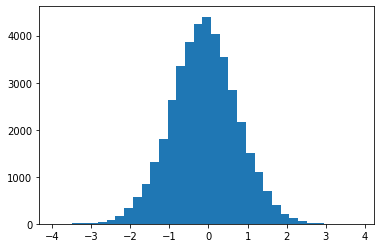

In [101]:
plt.hist(rmm2.rmm2,bins=35)

In [102]:
rmm2.to_csv('rmm2_conv_1905_2015.csv')